In [1]:
import os
import time
from math import log

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

In [3]:
columns_quant = ['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']

X = df[columns_quant]
y = df['is_display_clicked']

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

columns_scaled = X.select_dtypes(include=np.number).columns

## Méthode RFE

L'avantage de cette méthode est qu'elle dépend du modèle utilisé.

In [5]:
def run_RFE(model, n_features_to_select, X_scaled, y):
    # create the RFE model and select 3 attributes
    rfe = RFE(model, n_features_to_select=3)
    rfe = rfe.fit(X_scaled, y)

    # summarize the selection of the attributes
    print(rfe.support_)
    print(rfe.ranking_)

    rf_df = pd.DataFrame(rfe.ranking_,index=X.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)

    display(rf_df)

In [6]:
%%time
model = LogisticRegression()
run_RFE(model, 8, X_scaled, y)

[False  True False False False False False False False False False  True
  True]
[ 8  1  5 10  6  9  7 11  3  2  4  1  1]


,Rank
campaignctrlast24h,1
display_size,1
zonecostineuro,1
nbdisplay_1hour,2
nbdayssincelastclick,3
nbdisplayglobalapprox_1d_sum_xdevice,4
dayssincelastvisitdouble,5
ltf_nbpartnerdisplayssincelastclick,6
ltf_nbpartnerclick_90d,7
contextid,8


Wall time: 19.1 s


In [7]:
%%time
model = LogisticRegression()
run_RFE(model, 3, X_scaled, y)

[False  True False False False False False False False False False  True
  True]
[ 8  1  5 10  6  9  7 11  3  2  4  1  1]


,Rank
campaignctrlast24h,1
display_size,1
zonecostineuro,1
nbdisplay_1hour,2
nbdayssincelastclick,3
nbdisplayglobalapprox_1d_sum_xdevice,4
dayssincelastvisitdouble,5
ltf_nbpartnerdisplayssincelastclick,6
ltf_nbpartnerclick_90d,7
contextid,8


Wall time: 20.1 s


In [8]:
%%time
model = LogisticRegression()
run_RFE(model, 2, X_scaled, y)

[False  True False False False False False False False False False  True
  True]
[ 8  1  5 10  6  9  7 11  3  2  4  1  1]


,Rank
campaignctrlast24h,1
display_size,1
zonecostineuro,1
nbdisplay_1hour,2
nbdayssincelastclick,3
nbdisplayglobalapprox_1d_sum_xdevice,4
dayssincelastvisitdouble,5
ltf_nbpartnerdisplayssincelastclick,6
ltf_nbpartnerclick_90d,7
contextid,8


Wall time: 19.8 s


Pour ne pas avoir à définir un nombre de features, nous allons utiliser une méthode de Cross Validation qui permettra de calculer le nombre de features optimal.

## Méthode RFECV

In [9]:
def run_RFECV(model, min_features_to_select, X_scaled, y):

    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),
              scoring='recall',
              min_features_to_select=min_features_to_select)
    rfecv.fit(X_scaled, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (recall)")
    plt.plot(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_)
    plt.show()

    rfecv_df = pd.DataFrame(rfecv.ranking_,index=X.columns, columns=['Rank']).sort_values(by='Rank', ascending=True)
    rfecv_df.sort_values(by='Rank')

    display(rfecv_df)

Optimal number of features : 13


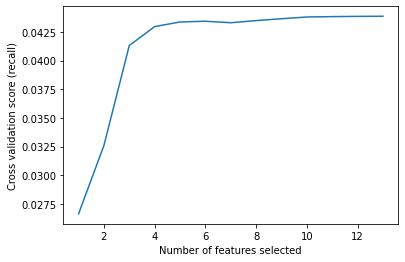

,Rank
contextid,1
campaignctrlast24h,1
dayssincelastvisitdouble,1
ltf_nbglobaldisplay_4w,1
ltf_nbpartnerdisplayssincelastclick,1
ltf_nbpartnerdisplay_90d,1
ltf_nbpartnerclick_90d,1
ltf_nbpartnersales_90d,1
nbdayssincelastclick,1
nbdisplay_1hour,1


Wall time: 1min 44s


In [10]:
%%time
model = LogisticRegression()
run_RFECV(model, 1, X_scaled, y)

Rajoutons à présent les variables catégorielles.

In [11]:
columns_cat = ['display_env',
            'target_env',
            'campaignscenario',
            'campaignvertical',
            'is_interstitial',
            'device_type']

In [12]:
X = df[columns_quant + columns_cat]
X = pd.get_dummies(X, columns=columns_cat, drop_first=True)
X_scaled = StandardScaler().fit_transform(X)
len(X.columns)

34

Optimal number of features : 28


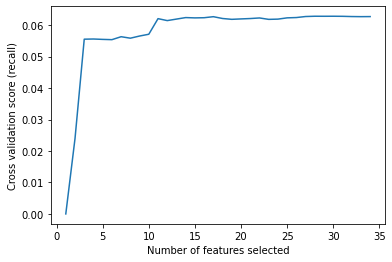

,Rank
contextid,1
device_type_Mobile - Other,1
device_type_Desktop - Safari,1
device_type_Desktop,1
is_interstitial_True,1
campaignvertical_200002.0,1
campaignvertical_129.0,1
campaignvertical_23.0,1
campaignvertical_20.0,1
campaignscenario_17,1


Wall time: 7min 58s


In [13]:
%%time
model = LogisticRegression()
run_RFECV(model, 1, X_scaled, y)

In [14]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:10:59
